# Top Molecules identified by each SBVS Method

This notebook allows to visualize the **top $k$ molecules identified by each SBVS method**, i.e., the two machine learning models and the three consensus strategies.

<div class="alert alert-warning">
The ranking was computed from the $30 \times 4 cv$ results.
</div>

- $30 \times 4 cv$ results were computed in [this notebook](./2_30x4CV_analysis.ipynb). 
- See the cells below for a more detailed description about these results and how they were generated to **obtain a single molecular ranking**.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdDepictor
import matplotlib.pyplot as plt

In [26]:
protein_name = 'fxa'

## Load the datasets
### Load the ensemble docking results

In [27]:
# Load the dataset
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1)
# Extract the response variable: Activity
y = df_dk_res['activity']

### Load the molecules saved as `rdkit` objects

In [28]:
# Load the dataframe with the rdkit molecules (no duplicates)
rdk_mols_file = '../2_Molecular_libraries/df_MOLECULES_no_duplicates.obj'
df_rdk_mols = pd.read_pickle(rdk_mols_file)
df_rdk_mols = df_rdk_mols.replace({'DEKOIS2': 'DEKOIS'})
df_rdk_mols = df_rdk_mols.set_index(['library', 'Lig'])

In [29]:
# Verify that both datasets match
assert np.all(X.index == df_rdk_mols.index)

## Load the `30x4cv` results
- This analysis was performed in the `2_30x4CV_analysis.ipynb` notebook.
- It contains the performance of the SBVS methods (ML and consensus strategies) of the 30x4cv analysis
- It also includes the information of each of the $120 \times 4$ validation sets:
    - The indices of the molecules used at each validation set.
    - The predictions of each of the SBVS methods:
        - The probabilities (*logits*) of the ML methods
        - The aggregation value determined by the consensus strategy.
        
- Results from other $30 \times 4 cv$ analysis can also be explored using this notebook, just change the `evaluation_name` variable:

```python
# Example
evaluation_name = f'{n_repeats}x{n_splits}cv_DEFAULT_HYPRMS'
```
- See the available $30 \times 4 cv$ results inside the `./cachedir` directory.

In [30]:
n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
filename = f'./cachedir/{evaluation_name}_{protein_name}'
cv30x4, y_preds, splits = joblib.load(filename)

#******************
#      NOTES
#******************

# cv30x4:  Are the results, per metric and per method, of the 30x4cv 

# y_preds: Is a dictionary where the key corresponds to the method's name
#          and the value is a list with the 120 predictions of the method
#          over the validation set. Each element of the list, is a numpy array
#.         with the predicions of the 25% of the molecules used for that
#          validation set. For the ML models, the values are the probabilities
#          returned by the classifier. For the Consensus scorings, the values
#.         are those resulting from the aggregation method applied over the raw
#          docking scores.

# splits:  is a list of 120 elements, where each element is a tuple where 
#          the second element is anumpy array with
#.         the indices of the molecules used for the validation sets.

# Therefore, each array inside y_preds contains the predictions of the method.

### Determine the rankings of each SBVS method after `30x4cv` analysis

In [31]:
def combine_cv_results(set_preds, k):
    '''
    Take `set_preds` which is a list of nxk elements,
    where each element is an array containing
    the indices of the samples comprising each validation
    set. 
    
    Returns a list of size 
    '''
    assert len(set_preds) % k == 0
    chunks = []
    for i in range(0, len(set_preds), k):
        chunks.append( set_preds[i: i+k])
    return chunks

In [32]:
# Number of validations sets = 120
n_val_sets   = n_repeats * n_splits
# Get only the validation sets
val_sets_ids = [i[1] for i in splits]

# List of results per method
m_preds_ranks = {}

for m_name in y_preds.keys():
    # Just get the validation set indices from the tuples
    # insidet the `splits` list
    set_preds = [
        pd.DataFrame(y_preds[m_name][i], 
                     index=val_set).rank(ascending=False)
         for i, val_set in enumerate(val_sets_ids)
    ]

    # Every k elements belong to 1 repeat of CV,
    # therefore, we can get the predictions per repeat
    # of all molecules using the `every_k_
    chunks = combine_cv_results(set_preds, k=n_splits)

    final_ranks = pd.concat([pd.concat(chunk, axis=0) 
                             for chunk in chunks], 
                            axis   = 1,
                            levels = None,
                            keys = range(1, n_repeats + 1))
    final_ranks.columns = final_ranks.columns.droplevel(1)
    final_ranks.columns.name = 'Repeats'
    final_ranks.index.name   = 'Molecules'

    # Add the labels: the y_true values
    mean_ranks = final_ranks.mean(axis = 1).to_frame(name='mean_rank')
    # Add the dataframe to the dictionary `m_preds_ranks`
    m_preds_ranks[m_name] = mean_ranks
# Convert the dictionary to a DataFrame
df_rank_preds = pd.concat(m_preds_ranks.values(), 
                          axis = 1, 
                          keys = y_preds.keys())
# For a better visualization of the table, let's format it
df_rank_preds.columns = df_rank_preds.columns.droplevel(1)
df_rank_preds = df_rank_preds.rank().astype('int')
Activities_list = ['Active' if i else 'Inactive' for i in y.values]
df_rank_preds.insert(loc = 0, column = 'Activity', value = Activities_list)
df_rank_preds.index = y.index
df_rank_preds.index.names = ['Library', 'Lig. Name']
df_rank_preds.columns.names = ['Ranking']
# Update the name of the columns
df_rank_preds = df_rank_preds.rename(columns = {'ml_lr'  : 'LR',
                      'ml_xgb' : 'GBT',
                      'ml_dclf': 'Dcfl',
                      'cs_MEAN': 'csAVG',
                      'cs_GEOM': 'csGEOM',
                      'cs_MIN' : 'csMIN'})

## Correlations between ranks

In [33]:
methods = ['LR','GBT','csAVG','csGEOM','csMIN']
# Correlation over the full set
df_corr = df_rank_preds[methods].corr(method = 'kendall').round(3)
df_corr

Ranking,LR,GBT,csAVG,csGEOM,csMIN
Ranking,,,,,
LR,1.000,0.453,0.294,0.296,0.204
GBT,0.453,1.000,0.115,0.113,0.089
csAVG,0.294,0.115,1.000,0.983,0.639
csGEOM,0.296,0.113,0.983,1.000,0.626
csMIN,0.204,0.089,0.639,0.626,1.000


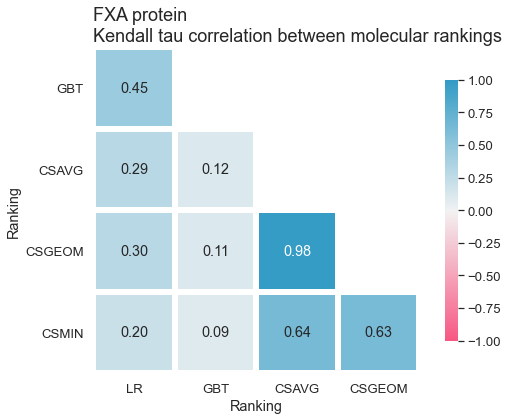

In [40]:
sns.set(style='whitegrid', font_scale = 1.2)
fig, ax = plt.subplots(figsize=(9, 6))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = f'{protein_name.upper()} protein\n' +\
        'Kendall tau correlation between molecular rankings'
plt.title(title, loc='left', fontsize=18)
plt.savefig(f'{protein_name}_rankings.pdf')
plt.show()

## Draw the  top $k$ molecules of each SBVS method

In [35]:
# Define a function to draw the top molecules

def draw_top_mols_by_method(method, n_mols=9, 
                            subImgSize = (300, 220),
                            alignSubstructure = False):
    '''
    `df_rank_preds` and `df_rdk_mols` should be created. 
    '''
    # Get the top molecules by the given method
    df_top_mols_by_method = df_rank_preds.sort_values(method).head(n_mols)
    # Drop the Dummy classifier for simplicity
    df_top_mols_by_method = df_top_mols_by_method.drop('Dcfl', axis = 1)
    idx = (df_top_mols_by_method).index
    mols_rows = df_rdk_mols.loc[idx]
    # Verify the indices match
    assert np.all(df_top_mols_by_method.index == mols_rows.index)
    # Add extra data => MW, num atoms, num rot
    df_top_mols_by_method = pd.concat([df_top_mols_by_method, 
                                       mols_rows[['MW','num_atoms','num_rot']]], 
                                      axis = 1)
    # Get the mol objects
    mols = mols_rows['mol_rdk'].to_list()

    # Create the molecular labels
    mols_labels = [ f'{name} ({lib})' for lib, name
                    in mols_rows.index]
    mols_labels = [f'{ac} - {lb}' for ac, lb in 
                   zip(df_top_mols_by_method['Activity'], mols_labels)]
    # Convert to 2D for visualization
    for i in mols: AllChem.Compute2DCoords(i)

    # Get the common cores
    match_all = rdFMCS.FindMCS(mols, completeRingsOnly = False,
                               bondCompare=Chem.rdFMCS.BondCompare.CompareAny)
    # Convert to mol objects
    mcs_all = Chem.MolFromSmarts(match_all.smartsString)
    if alignSubstructure:
        # Aling molecules to the Maximum common substructure
        AllChem.Compute2DCoords(mcs_all)
        subms = [x for x in mols 
                     if x.HasSubstructMatch(
                      mcs_all
                     )]
        for m in mols:
            _ = AllChem\
            .GenerateDepictionMatching2DStructure(m, mcs_all)

    # Draw the molecules
    rdDepictor.SetPreferCoordGen(False)
    img = Chem.Draw.MolsToGridImage(
         mols,
         molsPerRow = 3,
         legends = mols_labels,
         useSVG=True,
         highlightAtomLists=[ mol.GetSubstructMatch(mcs_all) for mol in mols], 
         subImgSize = subImgSize)
    return img, df_top_mols_by_method

### Logistic Regression

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                      
DUD     decoy_5325  Inactive   1    4      7       7      6  539.539   
        ligand_26     Active   2    8     14      17     18  533.527   
COCRYS  IVK           Active   3    3     83     102     26  537.921   
DUD     ligand_90     Active   4    1   2831    2858   1541  426.520   
        decoy_1192  Inactive   5    7     70      71     92  499.552   
DEKOIS  ligand_8      Active   6   11     31      30     19  547.561   
COCRYS  RR8           Active   7    9     29      30     22  532.981   
DUD     ligand_88     Active   8   14    979    1004    276  480.490   
        ligand_109    Active   9   18    970     995    163  534.460   

                    num_atoms  num_rot  
Library Lig. Name                       
DUD     decoy_5325         38        5  
        ligand_26          37        6  
COCRYS  IVK                37        6  
DUD     ligand_90          32        6  
        decoy_1192         36        5  
DEKOIS  ligand_8           40        5  
COCRYS  RR8                36        6  
DUD     ligand_88          35        6  
        ligand_109         38        6

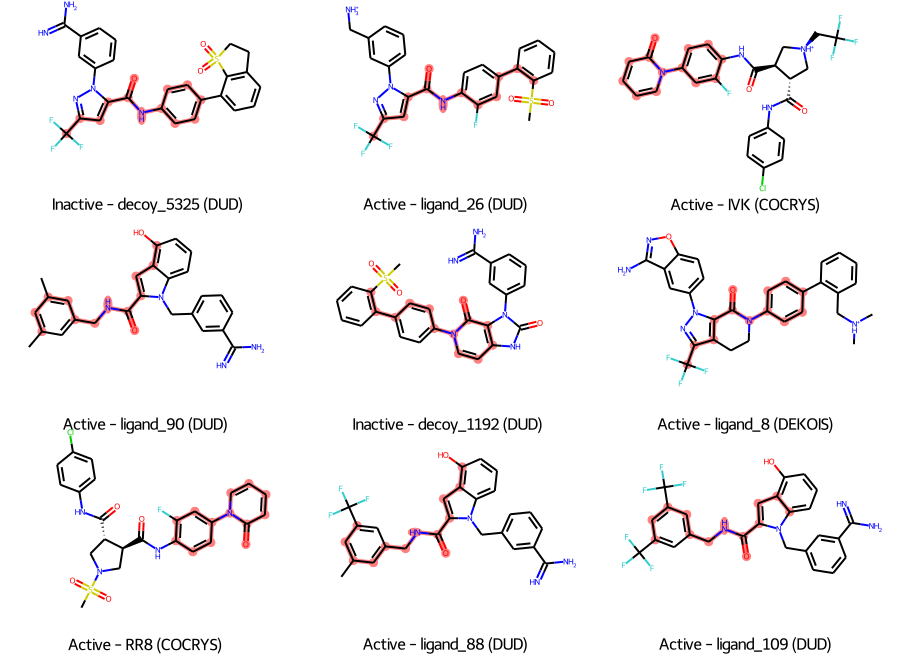

In [36]:
# Define the method
method = 'LR'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

### Gradient Boosting Trees

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                      
DUD     ligand_90     Active   4    1   2831    2858   1541  426.520   
        ligand_118    Active  21    2   2034    2007   2988  432.911   
COCRYS  IVK           Active   3    3     83     102     26  537.921   
DUD     decoy_5325  Inactive   1    4      7       7      6  539.539   
        ligand_91     Active  39    5   2248    2221   3140  412.493   
        ligand_103    Active  49    6   3013    2979   3650  477.362   
        decoy_1192  Inactive   5    7     70      71     92  499.552   
        ligand_26     Active   2    8     14      17     18  533.527   
COCRYS  RR8           Active   7    9     29      30     22  532.981   

                    num_atoms  num_rot  
Library Lig. Name                       
DUD     ligand_90          32        6  
        ligand_118         31        6  
COCRYS  IVK                37        6  
DUD     decoy_5325         38        5  
        ligand_91          31        6  
        ligand_103         31        6  
        decoy_1192         36        5  
        ligand_26          37        6  
COCRYS  RR8                36        6

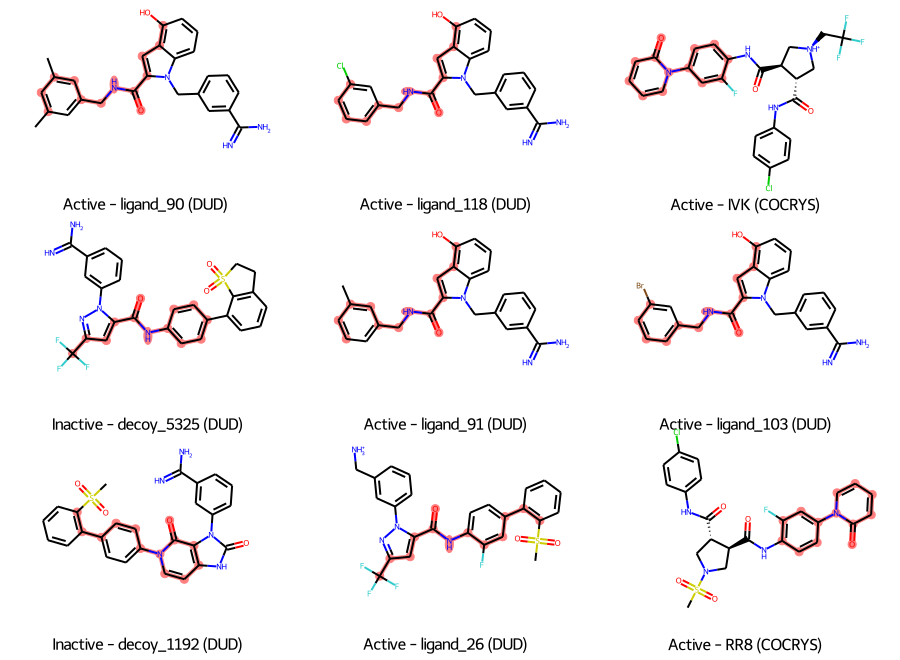

\begin{tabular}{lllrrrrrrrr}
\toprule
       &     &  Activity &  LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &     &      &        &         &        &        &            &          \\
\midrule
DUD & ligand\_90 &    Active &   4 &    1 &   2831 &    2858 &   1541 &  426.5 &         32 &        6 \\
       & ligand\_118 &    Active &  21 &    2 &   2034 &    2007 &   2988 &  432.9 &         31 &        6 \\
COCRYS & IVK &    Active &   3 &    3 &     83 &     102 &     26 &  537.9 &         37 &        6 \\
DUD & decoy\_5325 &  Inactive &   1 &    4 &      7 &       7 &      6 &  539.5 &         38 &        5 \\
       & ligand\_91 &    Active &  39 &    5 &   2248 &    2221 &   3140 &  412.5 &         31 &        6 \\
       & ligand\_103 &    Active &  49 &    6 &   3013 &    2979 &   3650 &  477.4 &         31 &        6 \\
       & decoy\_1192 &  Inactive &   5 &    7 &     70 &      71 &     92 &  499.6 &         36 

In [37]:
# Define the method
method = 'GBT'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Average Consensus strategy (csAVG)

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                      
COCRYS  LGL           Active  45   28      1       1      2  600.625   
        LGJ           Active  34   56      2       2      1  586.527   
        5QC           Active  11   42      3       3     10  589.598   
        L1D           Active  23   55      4       4     12  546.986   
DEKOIS  ligand_4      Active  40   37      5       5      9  475.554   
        ligand_15     Active  17   59      6       6     20  494.468   
DUD     decoy_5325  Inactive   1    4      7       7      6  539.539   
        decoy_4894  Inactive  15   35      8       8      7  498.588   
        decoy_5243  Inactive  79   92      9       9     16  489.577   

                    num_atoms  num_rot  
Library Lig. Name                       
COCRYS  LGL                44        6  
        LGJ                41        6  
        5QC                43        5  
        L1D                39        5  
DEKOIS  ligand_4           34        6  
        ligand_15          35        5  
DUD     decoy_5325         38        5  
        decoy_4894         36        5  
        decoy_5243         35        6

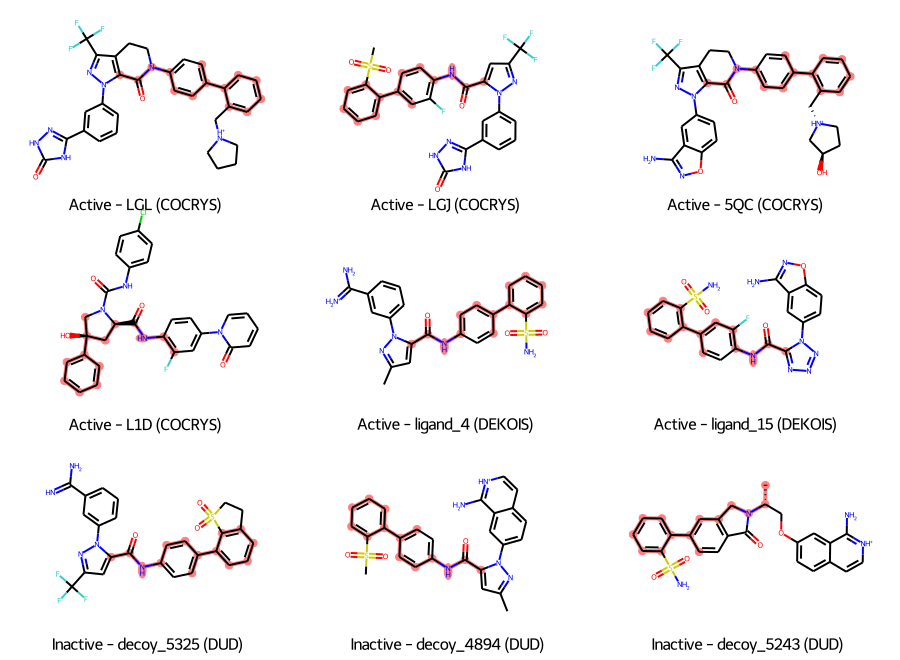

\begin{tabular}{lllrrrrrrrr}
\toprule
    &            &  Activity &  LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &     &      &        &         &        &        &            &          \\
\midrule
COCRYS & LGL &    Active &  45 &   28 &      1 &       1 &      2 &  600.6 &         44 &        6 \\
    & LGJ &    Active &  34 &   56 &      2 &       2 &      1 &  586.5 &         41 &        6 \\
    & 5QC &    Active &  11 &   42 &      3 &       3 &     10 &  589.6 &         43 &        5 \\
    & L1D &    Active &  23 &   55 &      4 &       4 &     12 &  547.0 &         39 &        5 \\
DEKOIS & ligand\_4 &    Active &  40 &   37 &      5 &       5 &      9 &  475.6 &         34 &        6 \\
    & ligand\_15 &    Active &  17 &   59 &      6 &       6 &     20 &  494.5 &         35 &        5 \\
DUD & decoy\_5325 &  Inactive &   1 &    4 &      7 &       7 &      6 &  539.5 &         38 &        5 \\
    & decoy\_489

In [38]:
# Define the method
method = 'csAVG'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Min Consensus strategy (csMIN)

Activity   LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                       
COCRYS  LGJ           Active   34   56      2       2      1  586.527   
        LGL           Active   45   28      1       1      2  600.625   
        LGK           Active   76   31     15      19      3  594.575   
        LGM           Active   53   13     24      26      4  546.655   
        FFG           Active  191  129    116     117      5  619.648   
DUD     decoy_5325  Inactive    1    4      7       7      6  539.539   
        decoy_4894  Inactive   15   35      8       8      7  498.588   
        decoy_4854  Inactive   57   50     27      26      8  490.605   
DEKOIS  ligand_4      Active   40   37      5       5      9  475.554   

                    num_atoms  num_rot  
Library Lig. Name                       
COCRYS  LGJ                41        6  
        LGL                44        6  
        LGK                42        5  
        LGM                41        6  
        FFG                45        7  
DUD     decoy_5325         38        5  
        decoy_4894         36        5  
        decoy_4854         35        8  
DEKOIS  ligand_4           34        6

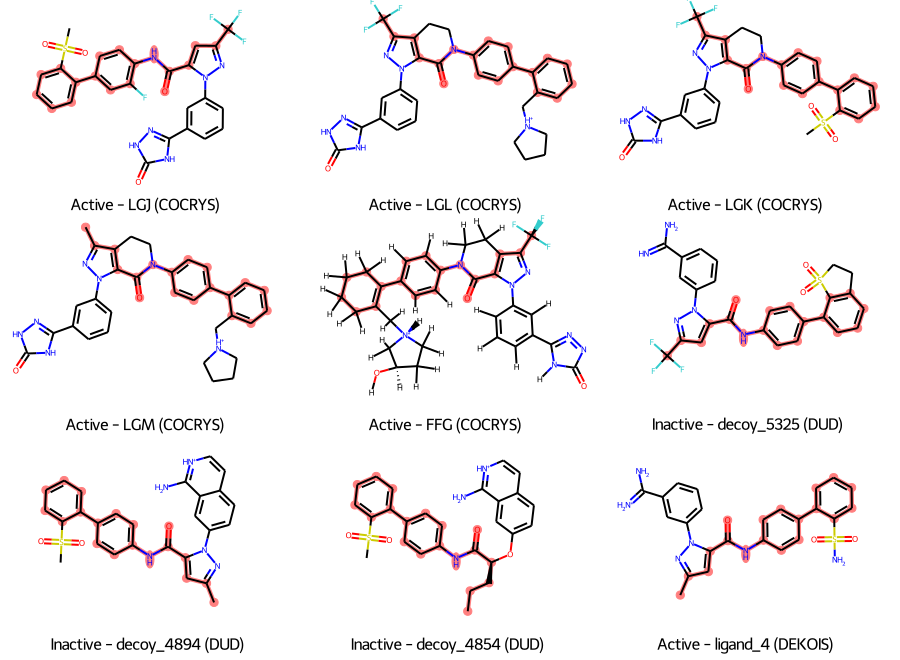

\begin{tabular}{lllrrrrrrrr}
\toprule
       &          &  Activity &   LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &      &      &        &         &        &        &            &          \\
\midrule
COCRYS & LGJ &    Active &   34 &   56 &      2 &       2 &      1 &  586.5 &         41 &        6 \\
       & LGL &    Active &   45 &   28 &      1 &       1 &      2 &  600.6 &         44 &        6 \\
       & LGK &    Active &   76 &   31 &     15 &      19 &      3 &  594.6 &         42 &        5 \\
       & LGM &    Active &   53 &   13 &     24 &      26 &      4 &  546.7 &         41 &        6 \\
       & FFG &    Active &  191 &  129 &    116 &     117 &      5 &  619.6 &         45 &        7 \\
DUD & decoy\_5325 &  Inactive &    1 &    4 &      7 &       7 &      6 &  539.5 &         38 &        5 \\
       & decoy\_4894 &  Inactive &   15 &   35 &      8 &       8 &      7 &  498.6 &         36 &        5 \\

In [39]:
# Define the method
method = 'csMIN'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)


# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())